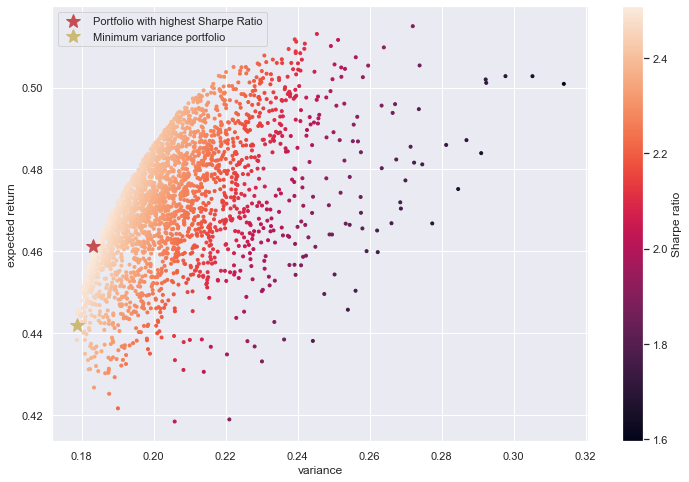

In [16]:
#1

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#Matlab 대신 seaborn
import seaborn as sns; sns.set() 
import pandas_datareader.data as web
import scipy.optimize as opt

#web data로부터 주식정보를 읽어와 dataframe에 합친다.
data = pd.DataFrame()
for code in ['005930', '000660', '035720', '035420'] : 
    data = pd.concat([data,web.DataReader(code, 'naver', start='2019-01-01', end='2020-01-01')['Close'].apply(int)], axis=1)
#dataframe의 열의 제목
data.columns = ['se', 'skh', 'kk','nvr']
#noa = 열의 길이
noa = len(data.columns)
#weights = 열의 길이를 랜덤화한 가중치
weights = np.random.random(noa)
#에다가 weights들의 합을 나눈다.
weights /= sum(weights)

# get returns. 즉 수익률을 구한다. 
ret = data.pct_change().dropna()

# 표본평균과 표본분산을 포트폴리오의 기대수익과 분산을 추정하는데 사용한다. *250 = 수익일수
port_mean = np.sum(weights * ret.mean() *250) # = 표본평균
port_var = np.dot(weights.T, np.dot(ret.cov()*250, weights)) # = 표본분산
port_std = np.sqrt(port_var) # = 표본표준편차

port_rets = []
port_std = []

#ret_std 정의 -> 수익의 표준편차
def ret_std(weight, ret):
    port_mean = np.sum(weight * ret.mean() *250)
    port_var = np.dot(weight.T, np.dot(ret.cov()*250, weight))
    port_std = np.sqrt(port_var)
    return port_mean, port_std

#2500 -> 10년간~
for w in range(2500):
    #weight 새로 정의
    weight = np.random.random(noa)
    weight /= np.sum(weight)
    mu, sig = ret_std(weight, ret)
    #10년간의 수익의 표준편차 구함(새로 정의한 weight 이용)
    port_rets.append(mu)
    port_std.append(sig)

def statistics(weights, rf=0):

    weights = np.array(weights)
    #portfolio 기대수익
    pret = np.sum(ret.mean() * weights) * 252 - rf
    #예상되는 포트폴리오 변동성
    pvol = np.sqrt(np.dot(weights.T, np.dot(ret.cov() * 252, weights)))
    #위 두개와 rf = 0 인 무위험의 Sharpe ratio 배열화하여 반환
    return np.array([pret, pvol, pret / pvol])


#sharpe ratio를 최대화하는 func
def min_func_sharpe(weights, rf=0):
    return -statistics(weights, rf)[2]

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))
noa * [1. / noa,]

#변동성을 최소화하는 func
def min_func_volatility(weights):
    return statistics(weights)[1] **2

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
#변수 범위
bnds = tuple((0, 1) for x in range(noa))
noa * [1. / noa,]
#최적화 알고리즘
opts = opt.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
optv = opt.minimize(min_func_volatility, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

#graph 그리기
plt.figure(figsize=(12, 8))
#점표현 -> portfolio의 stdiv, returns 이용
plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker='.')
    
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')
            # portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'y*', markersize=15.0, label = 'Minimum variance portfolio')
            # minimum variance portfolio  
#이하 표시 세부사항들
plt.legend()
plt.grid(True)
plt.xlabel('variance')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [1]:
#2
#가정.
rf = 0.02
#무위험 자산의 efficient frontier
slope = (statistics(opts['x'])[0] - rf) / statistics(opts['x'])[1]

var_list = [x*slope + rf for x in np.linspace(0.16,0.30,2500)]
# x = 다음 좌표들을 지나는 efficient frontier 선을 지나게 될것.
x =  np.linspace(0.16,0.30,2500)
y = var_list

plt.figure(figsize=(12, 8))
#random하게 점들을 분포
plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker='.')
plt.plot(x,y, label = 'mean-variance frontier with riskfree asset')

plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')

#그래프 세부사항들
plt.ylim((0.4, 0.55))
plt.legend()
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

NameError: name 'statistics' is not defined